In [1]:
#Load dependence
import pandas as pd
import numpy as np
from rdkit import Chem
import os
import torch
import torch.nn.functional as F
from sklearn.model_selection import KFold
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

from MultiTaskGNN.utils import gen_mol_form_smi, gen_ortho_sub_list, gen_meta_sub_list, make_reaction_graphs
from MultiTaskGNN.MT_GNN import MultiTaskDataset, MultiTaskGNN, evaluate

In [3]:
#Load raw data
df = pd.read_csv('./RuCHFunctionalizationDataset/dataset.csv')
df_DG = pd.read_csv('./RuCHFunctionalizationDataset/DG.csv')
df_RX = pd.read_csv('./RuCHFunctionalizationDataset/RX.csv')

cat_smi_list = df['catalyst'].to_list()
sol_smi_list = df['solvent'].to_list()
ligand_smi_list = df['ligand'].to_list()
ad_smi_list = df['addictive'].to_list()

In [5]:
#Transform the SMILES of four reaction components into MOL files
cat_mols = gen_mol_form_smi(cat_smi_list)
ligand_mols = gen_mol_form_smi(ligand_smi_list)
sol_mols = gen_mol_form_smi(sol_smi_list)
ad_mols = gen_mol_form_smi(ad_smi_list)

In [7]:
#Load target for the classification task
target = df['tag'].to_list()
target = np.array(target)

num = df['number'].to_list()
num = np.array(num)
num_DG = df['DG_num'].to_list()
num_DG = np.array(num_DG)
num_RX = df['RX_num'].to_list()
num_RX = np.array(num_RX)

In [9]:
#Prepare mechanistic-related discriptors for DG and RX
f_p_2 = df_DG['f+2'].tolist()
f_p_3 = df_DG['f+3'].tolist()
f_p_4 = df_DG['f+4'].tolist()
f_p_5 = df_DG['f+5'].tolist()
f_p_6 = df_DG['f+6'].tolist()
fukui1 = np.column_stack((f_p_2, f_p_3, f_p_4, f_p_5, f_p_6))

f_m_2 = df_DG['f-2'].tolist()
f_m_3 = df_DG['f-3'].tolist()
f_m_4 = df_DG['f-4'].tolist()
f_m_5 = df_DG['f-5'].tolist()
f_m_6 = df_DG['f-6'].tolist()
fukui2 = np.column_stack((f_m_2, f_m_3, f_m_4, f_m_5, f_m_6))

f_0_2 = df_DG['f0-2'].tolist()
f_0_3 = df_DG['f0-3'].tolist()
f_0_4 = df_DG['f0-4'].tolist()
f_0_5 = df_DG['f0-5'].tolist()
f_0_6 = df_DG['f0-6'].tolist()
fukui3 = np.column_stack((f_0_2, f_0_3, f_0_4, f_0_5, f_0_6))

Q_2 = df_DG['Q2'].tolist()
Q_3 = df_DG['Q3'].tolist()
Q_4 = df_DG['Q4'].tolist()
Q_5 = df_DG['Q5'].tolist()
Q_6 = df_DG['Q6'].tolist()
Qc_DG = np.column_stack((Q_2, Q_3, Q_4, Q_5, Q_6))

Qc_R = df_RX['Qc'].tolist()
Qc_R = np.array(Qc_R)
f0 = df_RX['f0'].tolist()
f0 = np.array(f0)
f_m = df_RX['f-'].tolist()
f_m = np.array(f_m)
f_p = df_RX['f+'].tolist()
f_p = np.array(f_p)

In [11]:
#Load targets for the two regression task of DG and RX
target_columns_DG = ['lumo', 'EA', 'bv-3.5']
target_DG = df_DG[target_columns_DG].values.tolist()
target_DG = np.array(target_DG)

target_columns_RX = ['somo', 'spin', 'bv-3.5']
target_RX = df_RX[target_columns_RX].values.tolist()
target_RX = np.array(target_RX)

In [13]:
#Create dictionaries for DG
DG_mol_folder_path = 'RuCHFunctionalizationDataset/train_DG'
DG_mols_list = []
for filename in sorted(os.listdir(DG_mol_folder_path), key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else float('inf')):
    mol_file_path = os.path.join(DG_mol_folder_path, filename)
    mol = Chem.MolFromMolFile(mol_file_path, removeHs=False)   
    if mol is not None:
        DG_mols_list.append(mol)
    else:
        print(f"Failed to load molecule from {mol_file_path}")

DG_dict = {}
for idx, mol in enumerate(DG_mols_list):
    DG_id = str(idx + 1)
    DG_dict[DG_id] = mol
    
DG_mols_for_r = []
for i in num:
    DG_number = num_DG[i]
    DG_mol = DG_dict[str(DG_number)]
    DG_mols_for_r.append(DG_mol)
    
train_val_num = len(DG_mols_for_r)

In [15]:
#Create dictionaries for RX    
RX_mol_folder_path = 'RuCHFunctionalizationDataset/train_RX'
RX_mols_list = []
for filename in sorted(os.listdir(RX_mol_folder_path), key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else float('inf')):
    mol_file_path = os.path.join(RX_mol_folder_path, filename)
    mol = Chem.MolFromMolFile(mol_file_path, removeHs=False)   
    if mol is not None:
        RX_mols_list.append(mol)
    else:
        print(f"Failed to load molecule from {mol_file_path}")

RX_dict = {}
for idx, mol in enumerate(RX_mols_list):
    RX_id = str(idx + 1)
    RX_dict[RX_id] = mol
    
RX_mols_for_r = []
for i in num:
    RX_number = num_RX[i]
    RX_mol = RX_dict[str(RX_number)]
    RX_mols_for_r.append(RX_mol)

In [17]:
#Find ortho- and meta-substituted DG
ortho_sub_list = gen_ortho_sub_list(DG_mols_for_r)
meta_sub_list = gen_meta_sub_list(DG_mols_for_r)

In [19]:
#Create reaction graphs            
v1_graphs, v2_graphs, reaction_graphs, decs, decs_mp, DG_graphs, RX_graphs = make_reaction_graphs(DG_mols_for_r,RX_mols_for_r,fukui1,fukui2,fukui3,Qc_DG,Qc_R,f0,f_m,f_p,ligand_mols,cat_mols,sol_mols,ad_mols)
reaction_graphs = np.array(reaction_graphs)
DG_graphs = np.array(DG_graphs)
RX_graphs = np.array(RX_graphs)

In [21]:
#Prepare dataset
target = torch.tensor(target, dtype=torch.long)
num = torch.tensor(num, dtype=torch.long)
target_DG = torch.tensor(target_DG, dtype=torch.float)
target_RX = torch.tensor(target_RX, dtype=torch.float)
dataset = MultiTaskDataset(DG_graphs, RX_graphs, reaction_graphs, target_DG, target_RX, target, num)

dataloader = GraphDataLoader(
    dataset,
    batch_size=30,
    drop_last=False,
    shuffle=True)

In [37]:
#Training
kf = KFold(n_splits=10, shuffle=True,random_state=1)
fold_num = 1
all_acc_list = []
all_loss_list = []
r2_1_all_list = []
r2_2_all_list = []
MAE1_all_list = []
MAE2_all_list = []

target_list_cm = []
pred_list_cm = []

wrong_list = []

output1_list = []

loss_list = []
loss_list1 = []
loss_list2 = []

MAE1_val_list = []
MAE2_val_list = []
r2_1_val_list = []
r2_2_val_list = []

attention_DG_all = torch.empty(0)
attention_r_all = torch.empty(0)
weight_list = []
h3_all = torch.empty(0)
num_val_end = []
h3_all_end = torch.empty(0)
pred1_all = []
label1_all = []
pred2_all = []
label2_all = []

for train_indices, val_indices in kf.split(dataset):
    train_acc_list = []
    valid_acc_list = [0.0]
    #print('train indices:', train_indices)
    #print('validation indices:', val_indices)
        
    train_dataset = [dataset[i] for i in train_indices]
    val_dataset = [dataset[i] for i in val_indices]

    train_loader = GraphDataLoader(
        train_dataset,
        batch_size=30,
        drop_last=False,
        shuffle=True)
    
    val_loader = GraphDataLoader(
        val_dataset,
        batch_size=30,
        drop_last=False,
        shuffle=True)
    
    model = MultiTaskGNN(79, 250, 3, 3, 5)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    
    predicted_val_list = []
    labels_val_list = []
    num_val_list = []
    
    for epoch in range(200):
        model.train()
        for inputs_task1, inputs_task2, inputs_task3, labels_task1, labels_task2, labels_task3, num in train_loader:
            opt.zero_grad()
            
            feat3 = inputs_task3.ndata['h']
            feat2 = inputs_task2.ndata['nfeat']
            feat1 = inputs_task1.ndata['nfeat']
            
            output1, output2, output3, attention_DG, attention_r, weight, h3 = model(inputs_task1, inputs_task2, inputs_task3, feat1, feat2, feat3)
            output1_list.extend(output1)
            
            loss1 = F.mse_loss(output1, labels_task1)
            loss2 = F.l1_loss(output2, labels_task2)
            loss3 = F.cross_entropy(output3, labels_task3)
            total_loss = loss1*0.4 + loss2*0.4 + loss3*0.2
            total_loss.backward()
            opt.step()
            
        train_acc, predicted_train, labels_train, num_train, MAE1_t, MAE2_t, r2_1_t, r2_2_t, attention_DG_t, attention_r_t, weight_t, h3_t, _, _, _, _ = evaluate(model, train_loader, ortho_sub_list, meta_sub_list)
        train_acc_list.append(train_acc)
        valid_acc, predicted_val, labels_val, num_val, MAE1_val, MAE2_val, r2_1_val, r2_2_val, attention_DG_v, attention_r_v, weight_v, h3_v, label1_v, pred1_v, label2_v, pred2_v = evaluate(model, val_loader, ortho_sub_list, meta_sub_list)
        valid_acc_list.append(valid_acc)
        MAE1_val_list.append(MAE1_val)
        MAE2_val_list.append(MAE2_val)
        r2_1_val_list.append(r2_1_val)
        r2_2_val_list.append(r2_2_val)
        loss4 = total_loss
        loss4 = loss4.detach() 
        loss1 = loss1.detach() 
        loss2 = loss2.detach() 
        loss4 = loss4.numpy()
        loss1 = loss1.numpy()
        loss2 = loss2.numpy()
        loss_list.append(loss4)
        loss_list1.append(loss1)
        loss_list2.append(loss2)
        
        if epoch == 199 :
            h3_all_end = torch.cat((h3_all_end,h3_v),dim=0)
            
        if max(valid_acc_list[:-1]) < valid_acc_list[-1]:
            attention_DG_all_m = torch.empty(0)
            attention_r_all_m = torch.empty(0)
            weight_list_m = []
            h3_all_m = torch.empty(0)
            num_val_end_m = torch.empty(0)
            target_max = []
            pred_max = []
            pred1 = []
            label1 = []
            pred2 = []
            label2 = []
            
            attention_DG_all_m = torch.cat((attention_DG_all_m, attention_DG_v), dim=0)
            attention_r_all_m = torch.cat((attention_r_all_m, attention_r_v), dim=0)
            weight_list_m.extend(weight_v)
            h3_all_m =torch.cat((h3_all_m, h3_v), dim=0)
            num_val_end_m = torch.cat((num_val_end_m, num_val[0]), dim=0)
            target_max.append(labels_val)
            pred_max.append(predicted_val)
            label1.append(label1_v)
            pred1.append(pred1_v)
            label2.append(label2_v)
            pred2.append(pred2_v)
        
    attention_DG_all = torch.cat((attention_DG_all, attention_DG_all_m), dim=0)
    attention_r_all = torch.cat((attention_r_all, attention_r_all_m), dim=0)
    h3_all =torch.cat((h3_all_m, h3_all), dim=0)
    num_val_end.append(num_val_end_m)
    pred1_all.append(pred1)
    label1_all.append(label1)
    pred2_all.append(pred2)
    label2_all.append(label2)
    
    target_list_cm.extend(target_max)
    pred_list_cm.extend(pred_max)

    print(
        "Fold {:02d} | Loss {:.4f} | Train Acc. {:.4f} | Validation Acc. {:.4f} ".format(
        fold_num, min(loss_list) , max(train_acc_list), max(valid_acc_list))
        )
    all_acc_list.append(max(valid_acc_list))
    all_loss_list.append(min(loss_list))
    r2_1_all_list.append(max(r2_1_val_list))
    r2_2_all_list.append(max(r2_2_val_list))
    MAE1_all_list.append(MAE1_val_list[-1])
    MAE2_all_list.append(MAE2_val_list[-1])
    fold_num += 1

average_accuracy = np.mean(all_acc_list)
average_loss = np.mean(all_loss_list)
average_r2_1 = np.mean(r2_1_all_list)
average_r2_2 = np.mean(r2_2_all_list)
average_MAE1 = np.mean(MAE1_all_list)
average_MAE2 = np.mean(MAE2_all_list)

target_list_cm = torch.cat(target_list_cm)
pred_list_cm = torch.cat(pred_list_cm)
target_list_cm = target_list_cm.numpy()
pred_list_cm = pred_list_cm.numpy()

print("Accuracy_all {:.4f}, Loss {:.4f}".format(average_accuracy, average_loss))


Fold 01 | Loss 0.0079 | Train Acc. 0.9478 | Validation Acc. 0.9231 
Fold 02 | Loss 0.0079 | Train Acc. 0.9522 | Validation Acc. 0.9231 
Fold 03 | Loss 0.0079 | Train Acc. 0.9565 | Validation Acc. 0.9231 
Fold 04 | Loss 0.0079 | Train Acc. 0.9565 | Validation Acc. 0.9615 
Fold 05 | Loss 0.0079 | Train Acc. 0.9522 | Validation Acc. 1.0000 
Fold 06 | Loss 0.0069 | Train Acc. 0.9652 | Validation Acc. 0.9231 
Fold 07 | Loss 0.0069 | Train Acc. 0.9481 | Validation Acc. 1.0000 
Fold 08 | Loss 0.0069 | Train Acc. 0.9567 | Validation Acc. 0.9600 
Fold 09 | Loss 0.0068 | Train Acc. 0.9697 | Validation Acc. 0.9200 
Fold 10 | Loss 0.0068 | Train Acc. 0.9567 | Validation Acc. 1.0000 
Accuracy_all 0.9534, Loss 0.0074


Text(50.722222222222214, 0.5, 'True')

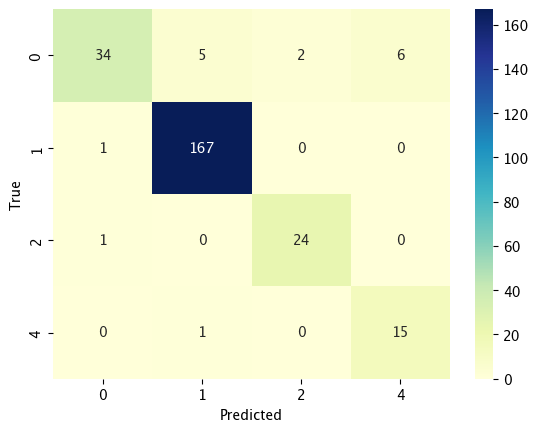

In [39]:
#Plotting confusion matrix
cm_1 = confusion_matrix(target_list_cm, pred_list_cm)
cm_1 = pd.DataFrame(cm_1,columns=["0","1","2","4"],index=["0","1","2","4"])
p = sns.heatmap(cm_1,cmap="YlGnBu",fmt="d",annot=True)
p.set_xlabel('Predicted')
p.set_ylabel('True') 

In [43]:
#Get scalered attention values
from sklearn.preprocessing import MinMaxScaler

num_val_end = torch.cat(num_val_end)
num_val_end = num_val_end.to(torch.int64)
num_val_end = num_val_end.numpy()
att_id = []
att_atom_id = []
att_values = []
att_values_scaled = []
total_edges = 0
attention_DG_all = attention_DG_all.squeeze()
for i in num_val_end:
    att_mole = []
    edges =  DG_graphs[i].edges()
    total_edges += len(edges[0])
    sub_tensor = attention_DG_all[total_edges - len(edges[0]):total_edges]
    num_atom = DG_mols_for_r[i].GetNumAtoms()
    attention_aggr = [0] * num_atom
    for j in range(len(edges[0])):
        attention_aggr[edges[0][j]] += sub_tensor[j]
        attention_aggr[edges[1][j]] += sub_tensor[j]
        degree = []
        for k, atom in enumerate(DG_mols_for_r[i].GetAtoms()):
            b=atom.GetDegree()
            degree.append(b)
        if j == len(edges[0]) - 1:
            #print("Processing for number {:.0f} is done:".format(i))
            for k, atom in enumerate(DG_mols_for_r[i].GetAtoms()):
                c = atom.GetAtomicNum()
                atten_aver = attention_aggr[k]/degree[k]/2
                if c != 1:
                    att_atom_id.append(k+1)
                    att_id.append(i)
                    atten_aver = atten_aver.detach()
                    att_values.append(atten_aver)
                    att_mole.append(atten_aver)
            att_mole_flat = np.array([val.item() for val in att_mole])
            att_mole_reshape = att_mole_flat.reshape(-1, 1)
            scaler = MinMaxScaler()
            att_mole_scal = scaler.fit_transform(att_mole_reshape)
            att_mole_scal = att_mole_scal.reshape(-1)
            att_values_scaled.append(att_mole_scal)
            #print("Total number of atoms is: {:.0f}".format(num_atom))      

att_id = np.array(att_id)
att_atom_id = np.array(att_atom_id)
att_values = np.array(att_values)
att_values_scaled = np.concatenate(att_values_scaled)
att_df = pd.DataFrame({
    "rxn_id": att_id,
    "atom": att_atom_id,
    "attention_value": att_values,
    "scaled_attention_values": att_values_scaled})

att_df.to_csv("attention.csv", index=False)

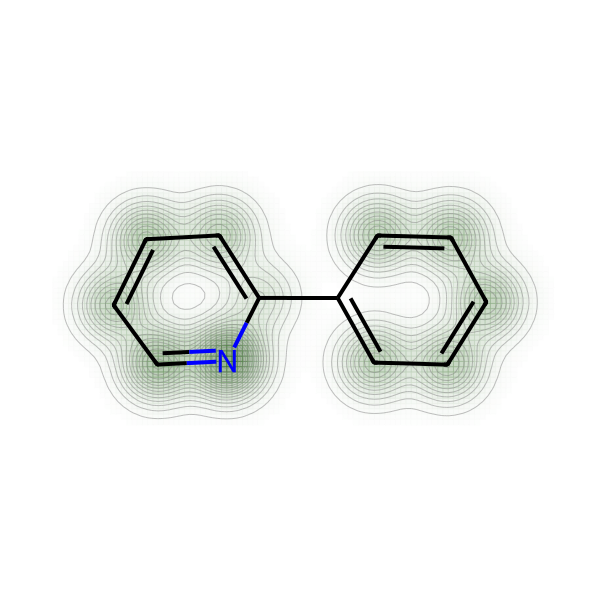

In [49]:
#Draw attention values, taking reaction_id = 0 as example
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
import io
from PIL import Image
from IPython.display import display

def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

d = Draw.MolDraw2DCairo(600, 600)
draw_options = d.drawOptions()
draw_options.bondLineWidth = 4.0
draw_options.atomLabelFontSize = 20  
draw_options.padding = 0.1 
draw_options.contourWidthMultiplier = 0.2 
num_att = 0
mol = DG_mols_for_r[num_att]
mol_no_h = Chem.RemoveHs(mol)
#att_draw = list(np.array(att_values_scaled[0:14], dtype=float))
att_draw = [0,
0.52,
0.531,
0.529,
0.532,
0.521,
0.266,
0.472,
0.558,
0.505,
0.696,
1]
SimilarityMaps.GetSimilarityMapFromWeights(mol_no_h, att_draw, draw2d=d, contourLines=20)

d.FinishDrawing()
img=show_png(d.GetDrawingText())
display(img)
img.save("att_{}.png".format(num_att))